In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
from pynwb import NWBFile, TimeSeries, NWBHDF5IO

# nwb_folder = '/root/capsule/data/s3/export/nwb/'
nwb_folder = '/home/jupyter/map-ephys/export/'

Some util funcs

In [2]:
def moving_average(a, n=3) :
    ret = np.nancumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n
    
def plot_session_lightweight(data, fitted_data=None, smooth_factor=5, base_color='y', ax=None, vertical=False):
    # sns.reset_orig()

    with sns.plotting_context("notebook", font_scale=1):

        choice_history, reward_history, p_reward = data

        # == Fetch data ==
        n_trials = np.shape(choice_history)[1]

        p_reward_fraction = p_reward[1, :] / (np.sum(p_reward, axis=0))

        ignored_trials = np.isnan(choice_history[0])
        rewarded_trials = np.any(reward_history, axis=0)
        unrewarded_trials = np.logical_not(np.logical_or(rewarded_trials, ignored_trials))

        # == Choice trace ==
        fig = None
        if ax is None:  
            fig = plt.figure(figsize=(8, 3), dpi=200)
            ax = fig.add_subplot(111)
            fig.subplots_adjust(left=0.1, right=0.8, bottom=0.05, top=0.7)

        # Rewarded trials
        xx = np.nonzero(rewarded_trials)[0] + 1
        yy = 0.5 + (choice_history[0, rewarded_trials] - 0.5) * 1.4
        ax.plot(*(xx, yy) if not vertical else [*(yy, xx)], 
                '|' if not vertical else '_', color='black', markersize=10, markeredgewidth=2)

        # Unrewarded trials
        xx = np.nonzero(unrewarded_trials)[0] + 1
        yy = 0.5 + (choice_history[0, unrewarded_trials] - 0.5) * 1.4
        ax.plot(*(xx, yy) if not vertical else [*(yy, xx)],
                '|' if not vertical else '_', color='gray', markersize=6, markeredgewidth=1)

        # Ignored trials
        xx = np.nonzero(ignored_trials)[0] + 1
        yy = [1.1] * sum(ignored_trials)
        ax.plot(*(xx, yy) if not vertical else [*(yy, xx)],
                'x', color='red', markersize=2, markeredgewidth=0.5, label='ignored')

        # Base probability
        xx = np.arange(0, n_trials) + 1
        yy = p_reward_fraction
        ax.plot(*(xx, yy) if not vertical else [*(yy, xx)],
                color=base_color, label='base rew. prob.', lw=1.5)

        # Smoothed choice history
        y = moving_average(choice_history, smooth_factor)
        x = np.arange(0, len(y)) + int(smooth_factor / 2) + 1
        ax.plot(*(x, y) if not vertical else [*(y, x)],
                linewidth=1.5, color='black', label='choice (smooth = %g)' % smooth_factor)

        # For each session, if any
        if fitted_data is not None:
            ax.plot(np.arange(0, n_trials), fitted_data[1, :], linewidth=1.5, label='model')

        ax.legend(fontsize=5, loc='upper left', bbox_to_anchor=(1, 1.3))
        
        if not vertical:
            ax.set_yticks([0, 1])
            ax.set_yticklabels(['Left', 'Right'])
        else:
            ax.set_xticks([0, 1])
            ax.set_xticklabels(['Left', 'Right'])
    
    # ax.set_xlim(0,300)

    # fig.tight_layout()
    sns.despine(trim=True, ax=ax)

    return fig, ax

## Available ephys sessions

In [3]:
os.listdir(nwb_folder)

['HH08_20210812_165205_s49.nwb',
 'HH08_20210813_163303_s50.nwb',
 'HH13_20211113_113114_s43.nwb',
 'HH13_20211102_170506_s33.nwb',
 'test_delay_response',
 'HH13_20211105_153750_s36.nwb',
 '.ipynb_checkpoints',
 'HH08_20210814_180826_s51.nwb',
 'HH16_20211208_143638_s17.nwb',
 'test_new',
 'HH09_20210613_202710_s60.nwb',
 'HH09_20210612_141829_s59.nwb',
 'HH13_20211112_130005_s42.nwb',
 'HH16_20211209_181917_s18.nwb',
 'HH09_20210609_162815_s57.nwb',
 'HH13_20211106_142344_s37.nwb',
 'HH08_20210815_181935_s52.nwb',
 'HH13_20211117_110858_s45.nwb',
 'HH13_20211103_164936_s34.nwb',
 'HH09_20210418_230003_s47.nwb']

## Load one session

In [4]:
nwb_file = 'HH08_20210812_165205_s49.nwb'

io = NWBHDF5IO(nwb_folder + nwb_file, mode='r')
nwb = io.read()

In [5]:
nwb

root pynwb.file.NWBFile at 0x140265158750032
Fields:
  acquisition: {
    BehavioralEvents <class 'pynwb.behavior.BehavioralEvents'>,
    BehavioralTimeSeries <class 'pynwb.behavior.BehavioralTimeSeries'>
  }
  devices: {
    18005108622 (neuropixels 1.0 - 3B) <class 'pynwb.device.Device'>,
    18005123491 (neuropixels 1.0 - 3B) <class 'pynwb.device.Device'>
  }
  electrode_groups: {
    18005108622 1-384 <class 'pynwb.ecephys.ElectrodeGroup'>,
    18005123491 1-384 <class 'pynwb.ecephys.ElectrodeGroup'>
  }
  electrodes: electrodes <class 'hdmf.common.table.DynamicTable'>
  experiment_description: moving lickports, delay period, early lick punishment, sound GO cue then free choice
  experimenter: ['HH']
  file_create_date: [datetime.datetime(2023, 3, 24, 6, 20, 20, 128870, tzinfo=tzlocal())]
  identifier: HH08_20210812_165205_s49
  institution: Janelia Research Campus / Allen Institute
  intervals: {
    trials <class 'pynwb.epoch.TimeIntervals'>
  }
  keywords: <HDF5 dataset "keyword

## Behavioral trials

In [6]:
df_trials = nwb.trials.to_dataframe()
df_trials

,start_time,stop_time,trial,trial_uid,task,task_protocol,trial_instruction,early_lick,outcome,auto_water,free_water,choice,left_reward_prob,right_reward_prob,left_action_value,right_action_value,rpe
id,,,,,,,,,,,,,,,,,
0,-0.9609,8.5312,1,40956,foraging,100,none,no early,hit,0,0,right,0.400,0.050,0.000000,0.626446,1.000000
1,8.5312,14.9461,2,40957,foraging,100,none,early,miss,0,0,right,0.400,0.050,0.000000,0.576079,-0.626446
2,14.9461,26.8620,3,40958,foraging,100,none,early,hit,0,0,left,0.400,0.050,0.626446,0.515175,1.000000
3,26.8620,33.6515,4,40959,foraging,100,none,early,hit,0,0,left,0.400,0.050,0.860457,0.460709,0.373554
4,33.6515,39.5803,5,40960,foraging,100,none,early,miss,0,0,left,0.400,0.050,0.791276,0.412001,-0.860457
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
747,5144.7561,5155.0393,748,41703,foraging,100,none,no early,miss,0,0,left,0.386,0.064,0.783673,0.071904,-0.852189
748,5155.0393,5166.4883,749,41704,foraging,100,none,early,miss,0,0,left,0.386,0.064,0.720666,0.064303,-0.783673
749,5166.4883,5172.8043,750,41705,foraging,100,none,no early,hit,0,0,left,0.386,0.064,0.895653,0.057504,0.279334


(<Figure size 1600x600 with 1 Axes>, <AxesSubplot:>)

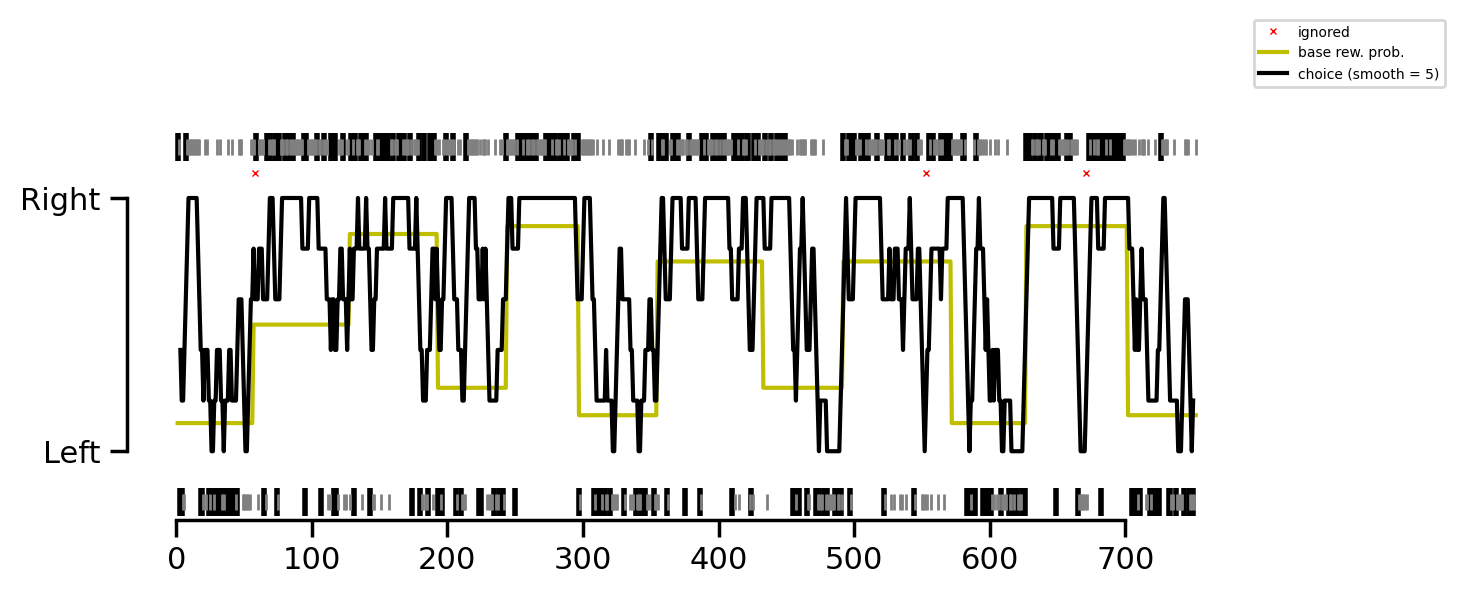

In [7]:
# Reformat data
_choice_history = df_trials.choice.values
choice_history = np.array([{'left': 0, 'right': 1, 'null': np.nan}[c] for c in _choice_history])

_reward = df_trials.outcome
reward_history = np.zeros([2, len(_reward)])  # .shape = (2, N trials)
for c in (0, 1):
    reward_history[c, choice_history==c] = (_reward[choice_history==c] == 'hit').astype(int)
    
p_reward = np.vstack([df_trials.left_reward_prob, df_trials.right_reward_prob])

# Plot session
plot_session_lightweight([np.array([choice_history]), reward_history, p_reward])

Also I exported the model fitting results (trial-based Q value etc.)

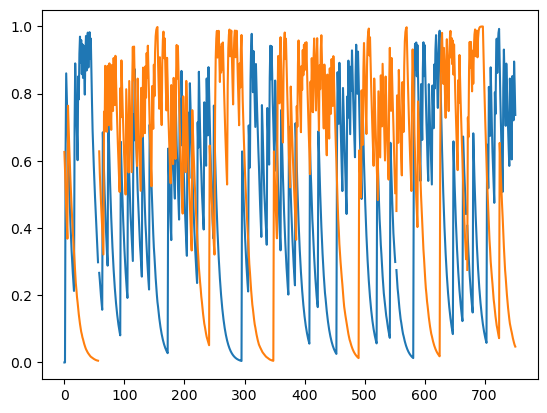

In [8]:
plt.plot(df_trials.left_action_value)
plt.plot(df_trials.right_action_value)

## Behavioral events

#### Here is the trial structure

1. In the inter-trial-interval (ITI), lickports are far from the mice.
2. At the trial start, lickports move forward to the "ready" position (`lickportready`)
3. A "no-lick period" starts (relatively short in my experiments, ~0.2-0.5 sec)
4. In the "no-lick period", if there is a "early lick", add a 2 sec timeout, and go back to `3` (still in the same trial)
5. If there is no early lick, deliver a `go_cue` sound, and a "response window" starts (typically 5 sec)
6. If there is any lick in the response window:
    <br>i. The first lick after the go cue is considered as `choice`. Deliver reward if a reward exists on the chosen lickport ("hit"), otherwise, "miss"
   <br>ii. If there is no more lick in any 1-second window, go to `8`. (In other words, if the mouse keeps licking, the trial will become very long)
   <br>iii. If there is any lick to the other lickport than the "choice", this trial is "double-dipped". In part of experiments, the trial will be terminated (go to `8`) to discourage double-dipping.
7. If there is no lick in the response window, this trial is an "ignore" trial, and go to `8`.
8. `trialend`: lickports are retracted and IT starts.## Behavioral trials

In [10]:
behav_events = nwb.acquisition['BehavioralEvents']
behav_events

BehavioralEvents pynwb.behavior.BehavioralEvents at 0x140265158898256
Fields:
  time_series: {
    choice <class 'pynwb.base.TimeSeries'>,
    go <class 'pynwb.base.TimeSeries'>,
    left_lick <class 'pynwb.base.TimeSeries'>,
    lickportready <class 'pynwb.base.TimeSeries'>,
    reward <class 'pynwb.base.TimeSeries'>,
    right_lick <class 'pynwb.base.TimeSeries'>,
    trialend <class 'pynwb.base.TimeSeries'>
  }

For example, get all go cue times (all times are relative to the first trial start of a session, in sec)

In [9]:
go_cue = behav_events['go'].timestamps[:]
print(go_cue[:20])
len(go_cue)

[  0.62022  11.47644  15.70156  28.21244  35.01277  40.74638  44.94521
  59.29802  66.69001  71.48369  76.29954  80.45469  84.44575  89.2681
  94.27259  99.7562  103.37904 109.84585 120.86733 132.30777]


752

Plot events

(0.0, 100.0)

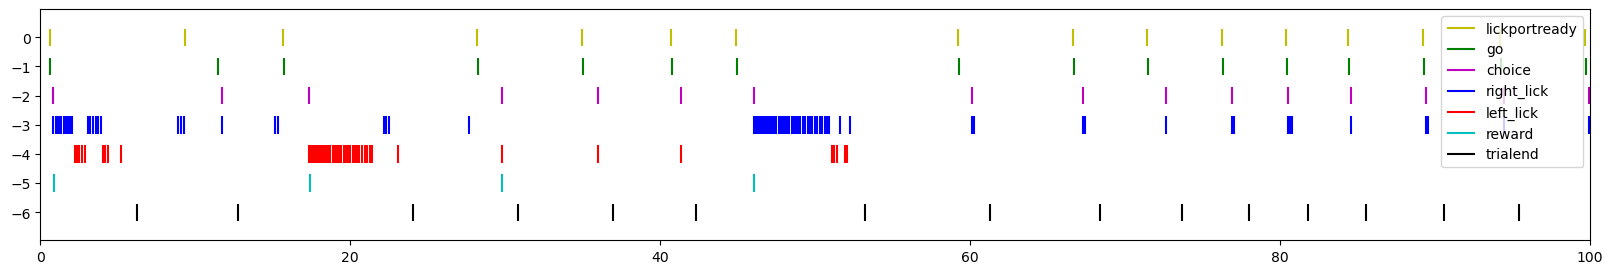

In [11]:
event_color_map = {'lickportready': 'y', 'go': 'g', 'choice': 'm', 'right_lick': 'b', 'left_lick': 'r', 'reward': 'c', 'trialend': 'k'}
event_times = [behav_events[x].timestamps[:] for x in event_color_map]

fig, ax = plt.subplots(1, 1, figsize=(20, 3))
ax.eventplot(event_times, colors=list(event_color_map.values()), linelengths=0.6, lineoffsets=-1)
ax.legend(event_color_map)
ax.set_xlim((0, 100))

## DLC results

DLC results are stored in nwb.acquisition['BehavioralTimeSeries']

In [11]:
dlc = nwb.acquisition['BehavioralTimeSeries']
dlc

BehavioralTimeSeries pynwb.behavior.BehavioralTimeSeries at 0x140164264854048
Fields:
  time_series: {
    Camera0_side_jaw <class 'pynwb.base.TimeSeries'>,
    Camera0_side_nose <class 'pynwb.base.TimeSeries'>,
    Camera0_side_pupil_side_Down <class 'pynwb.base.TimeSeries'>,
    Camera0_side_pupil_side_Left <class 'pynwb.base.TimeSeries'>,
    Camera0_side_pupil_side_Right <class 'pynwb.base.TimeSeries'>,
    Camera0_side_pupil_side_Up <class 'pynwb.base.TimeSeries'>,
    Camera0_side_tongue <class 'pynwb.base.TimeSeries'>,
    Camera0_side_tongue_side_Down <class 'pynwb.base.TimeSeries'>,
    Camera0_side_tongue_side_Mid <class 'pynwb.base.TimeSeries'>,
    Camera0_side_tongue_side_Up <class 'pynwb.base.TimeSeries'>,
    Camera0_side_whisker_Back <class 'pynwb.base.TimeSeries'>,
    Camera0_side_whisker_Front <class 'pynwb.base.TimeSeries'>,
    Camera0_side_whisker_Mid <class 'pynwb.base.TimeSeries'>,
    Camera1_bottom_jaw <class 'pynwb.base.TimeSeries'>,
    Camera1_bottom_left_p

In [12]:
feature = 'Camera1_bottom_tongue'
bottom_tongue = dlc[feature]
bottom_tongue

Camera1_bottom_tongue pynwb.base.TimeSeries at 0x140164264647792
Fields:
  comments: no comments
  conversion: 1.0
  data: <HDF5 dataset "data": shape (1402146, 3), type "<f8">
  description: Time series for tongue position: ('tongue_x', 'tongue_y', 'tongue_likelihood')
  interval: 1
  offset: 0.0
  resolution: -1.0
  timestamps: <HDF5 dataset "timestamps": shape (1402146,), type "<f8">
  timestamps_unit: seconds
  unit: a.u.

`data` field has a shape of (n_time_stamps * 3). 

In [13]:
bottom_tongue.data[:].shape

(1402146, 3)

The second dimension is: x coord (in pixel), y coord (in pixel), and likelihood (confidence of the model)

In [14]:
x, y, likelihood = bottom_tongue.data[:].T   

Session time is stored in `timestamps`

In [43]:
time = bottom_tongue.timestamps[:]
time.shape

(1402146,)

Filtered by valid likelihood

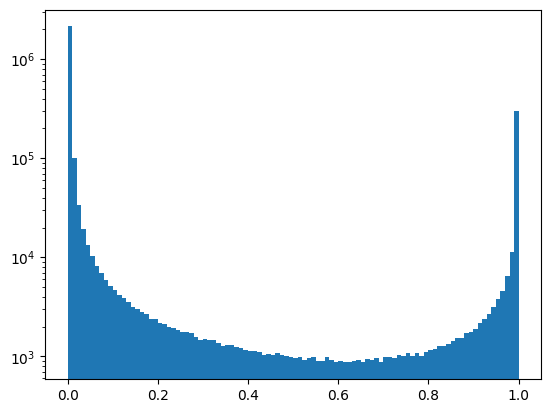

In [116]:
_ = plt.hist(likelihood, 100, log=True)

In [21]:
likelihood_threshold = 0.95
invalid = likelihood < likelihood_threshold
# likelihood[invalid] = np.nan
x[invalid] = np.nan
y[invalid] = np.nan

Example traces

Text(0.5, 0.98, 'Camera1_bottom_tongue')

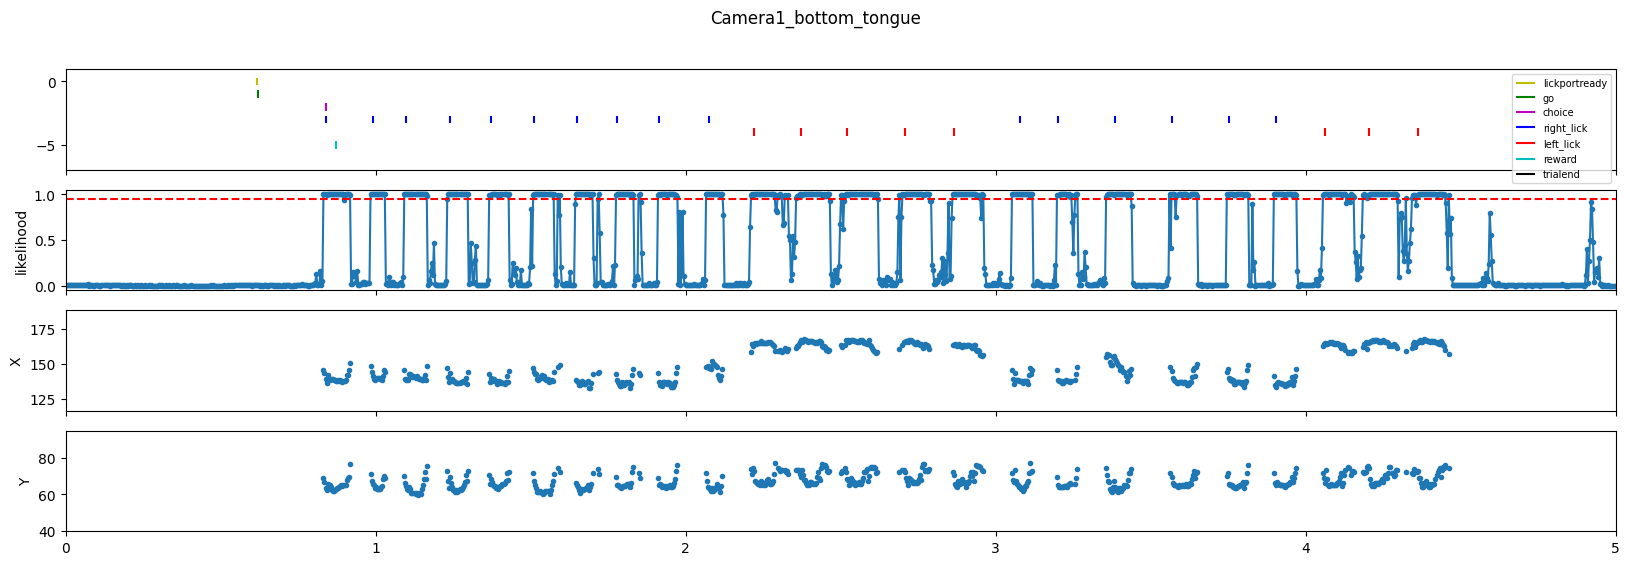

In [40]:
fig, ax = plt.subplots(4, 1, figsize=(20, 6), sharex=True)
ax[0].eventplot(event_times, colors=list(event_color_map.values()), linelengths=0.6, lineoffsets=-1)
ax[0].legend(event_color_map, fontsize=7)

ax[1].plot(time, likelihood, '.-')
ax[1].axhline(y=likelihood_threshold, color='r', ls='--')
ax[1].set(ylabel='likelihood')

ax[2].plot(time, x, '.'); ax[2].set(ylabel=f'X')
ax[3].plot(time, y, '.'); ax[3].set(ylabel=f'Y')
ax[3].set_xlim((0, 5))
fig.suptitle(feature)

## Mapping from the raw video files to trial number and session time (align BehavNet to behavior, DLC, and ephys)

In [ ]:
video_file_mapping = nwb.scratch['video_frame_mapping'].to_dataframe()
video_file_mapping

,subject_id,session,tracking_device,trial,video_trial_num,tracking_file,frame_time
id,,,,,,,
0,473360,49,Camera 0,1,1,HH08/HH08_S01_20210812/side_face_1-0000DLC_res...,"[6.573219, 6.576504, 6.579804, 6.583104, 6.586..."
1,473360,49,Camera 0,2,2,HH08/HH08_S01_20210812/side_face_2-0000DLC_res...,"[15.117745, 15.12103, 15.12433, 15.12763, 15.1..."
2,473360,49,Camera 0,3,3,HH08/HH08_S01_20210812/side_face_3-0000DLC_res...,"[21.533255, 21.53654, 21.539845, 21.543145, 21..."
3,473360,49,Camera 0,4,4,HH08/HH08_S01_20210812/side_face_4-0000DLC_res...,"[33.448606, 33.451896, 33.455196, 33.458498, 3..."
4,473360,49,Camera 0,5,5,HH08/HH08_S01_20210812/side_face_5-0000DLC_res...,"[40.238831, 40.242121, 40.245421, 40.248721, 4..."
...,...,...,...,...,...,...,...
1495,473360,49,Camera 1,748,750,HH08/HH08_S01_20210812/bottom_face_750-0000DLC...,"[5151.347634, 5151.350919, 5151.354219, 5151.3..."
1496,473360,49,Camera 1,749,751,HH08/HH08_S01_20210812/bottom_face_751-0000DLC...,"[5161.829102, 5161.832387, 5161.835687, 5161.8..."
1497,473360,49,Camera 1,750,752,HH08/HH08_S01_20210812/bottom_face_752-0000DLC...,"[5173.079628, 5173.082913, 5173.086213, 5173.0..."


- `tracking_file`: the DLC output .csv file that has been ingested, from which you can retrieve the raw video file name <br>
- `video_trial_num`: the trial number in the raw video file name (e.g., side_face_{`video_trial_num`}-0000.avi)<br>
- `trial`: the corresponding behavioral trial number (same as in `nwb.trials` above). Note that sometimes `trial`$\neq$`video_trial_num` due to glitches in acquisition. <br>
- `frame_time`: the session time for each frame in the corresponding video file. Aligned with behavioral events above.

## Ephys recordings

In [59]:
df_units = nwb.units.to_dataframe()
df_units

,insertion_number,sampling_rate,unit_quality,unit_posx,unit_posy,unit_amp,unit_snr,isi_violation,avg_firing_rate,drift_metric,...,repolarization_slope,recovery_slope,spread,velocity_above,velocity_below,unit_id,spike_times,electrodes,waveform_mean,waveform_sd
id,,,,,,,,,,,,,,,,,,,,,
0,2,30000,good,27.0,0.0,160.462331,7.283774,0.003028,47.633500,NaN,...,0.712398,-0.245221,120.0,1.030150,NaN,0,"[-7.468601606247252, -7.459768271014163, -7.43...",location \ id ...,"[0.3029496492985972, 0.056362725450901804, -0....",[nan]
1,2,30000,good,27.0,80.0,77.286874,3.128028,0.001155,13.463300,NaN,...,0.346459,-0.084980,260.0,0.973961,-2.541040e+00,13,"[-7.296834902639293, -7.222834886724357, -7.21...",location \ id ...,"[0.3459934277047523, -0.009479271991911021, -0...",[nan]
2,2,30000,good,11.0,100.0,224.812200,8.996118,0.000000,2.152620,NaN,...,0.949291,-0.205749,260.0,1.148500,-2.060300e+00,16,"[-7.013368175008382, -6.29173468647574, -5.863...",location \ id ...,"[0.10516826923076925, 0.6911057692307693, 0.79...",[nan]
3,2,30000,good,27.0,320.0,78.242861,4.015200,0.013836,1.957570,NaN,...,0.155926,-0.013086,300.0,-1.156060,8.339320e-01,24,"[-6.6464347627599025, -6.531101404622209, -5.7...",location \ id ...,"[-0.46218345905172414, -0.6061422413793104, -0...",[nan]
4,2,30000,multi,27.0,200.0,84.003283,3.989731,0.098470,3.164300,NaN,...,0.329729,-0.014259,300.0,0.858459,-9.404780e-01,25,"[-7.253134893240878, -7.149168204214442, -7.14...",location \ id ...,"[-0.1448249227600412, -0.3282698249227601, -0....",[nan]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220,2,30000,multi,11.0,540.0,93.528803,3.625702,0.092722,3.436450,NaN,...,0.391751,-0.045557,80.0,0.686767,-8.470330e-18,1137,"[-6.7752347904604955, -6.3183346921965144, -5....",location \ id ...,"[0.11295180722891568, -0.13648343373493976, 0....",[nan]
221,2,30000,good,59.0,1400.0,122.312363,4.663829,0.050087,1.048310,NaN,...,0.520493,-0.066652,80.0,0.343384,-6.867670e-01,1155,"[-0.5791667912261378, 12.96613612191701, 21.29...",location \ id ...,"[0.17237239297475304, 0.3267357299670692, 0.39...",[nan]
222,2,30000,good,59.0,1680.0,174.870208,5.767943,0.000000,0.540265,NaN,...,0.692989,-0.127468,260.0,1.117030,-1.424790e+00,1163,"[-6.119467982760248, 9.62813540402432, 10.5696...",location \ id ...,"[-0.7013777955271565, -0.9759384984025559, -1....",[nan]


In [65]:
df_units.keys()

Index(['insertion_number', 'sampling_rate', 'unit_quality', 'unit_posx',
       'unit_posy', 'unit_amp', 'unit_snr', 'isi_violation', 'avg_firing_rate',
       'drift_metric', 'presence_ratio', 'amplitude_cutoff',
       'isolation_distance', 'l_ratio', 'd_prime', 'nn_hit_rate',
       'nn_miss_rate', 'silhouette_score', 'max_drift', 'cumulative_drift',
       'duration', 'halfwidth', 'pt_ratio', 'repolarization_slope',
       'recovery_slope', 'spread', 'velocity_above', 'velocity_below',
       'unit_id', 'spike_times', 'electrodes', 'waveform_mean', 'waveform_sd'],
      dtype='object')

Align spikes to behavioral events

[(-5.0, 100.0), Text(0.5, 0, 'time (sec)'), Text(0, 0.5, 'unit #')]

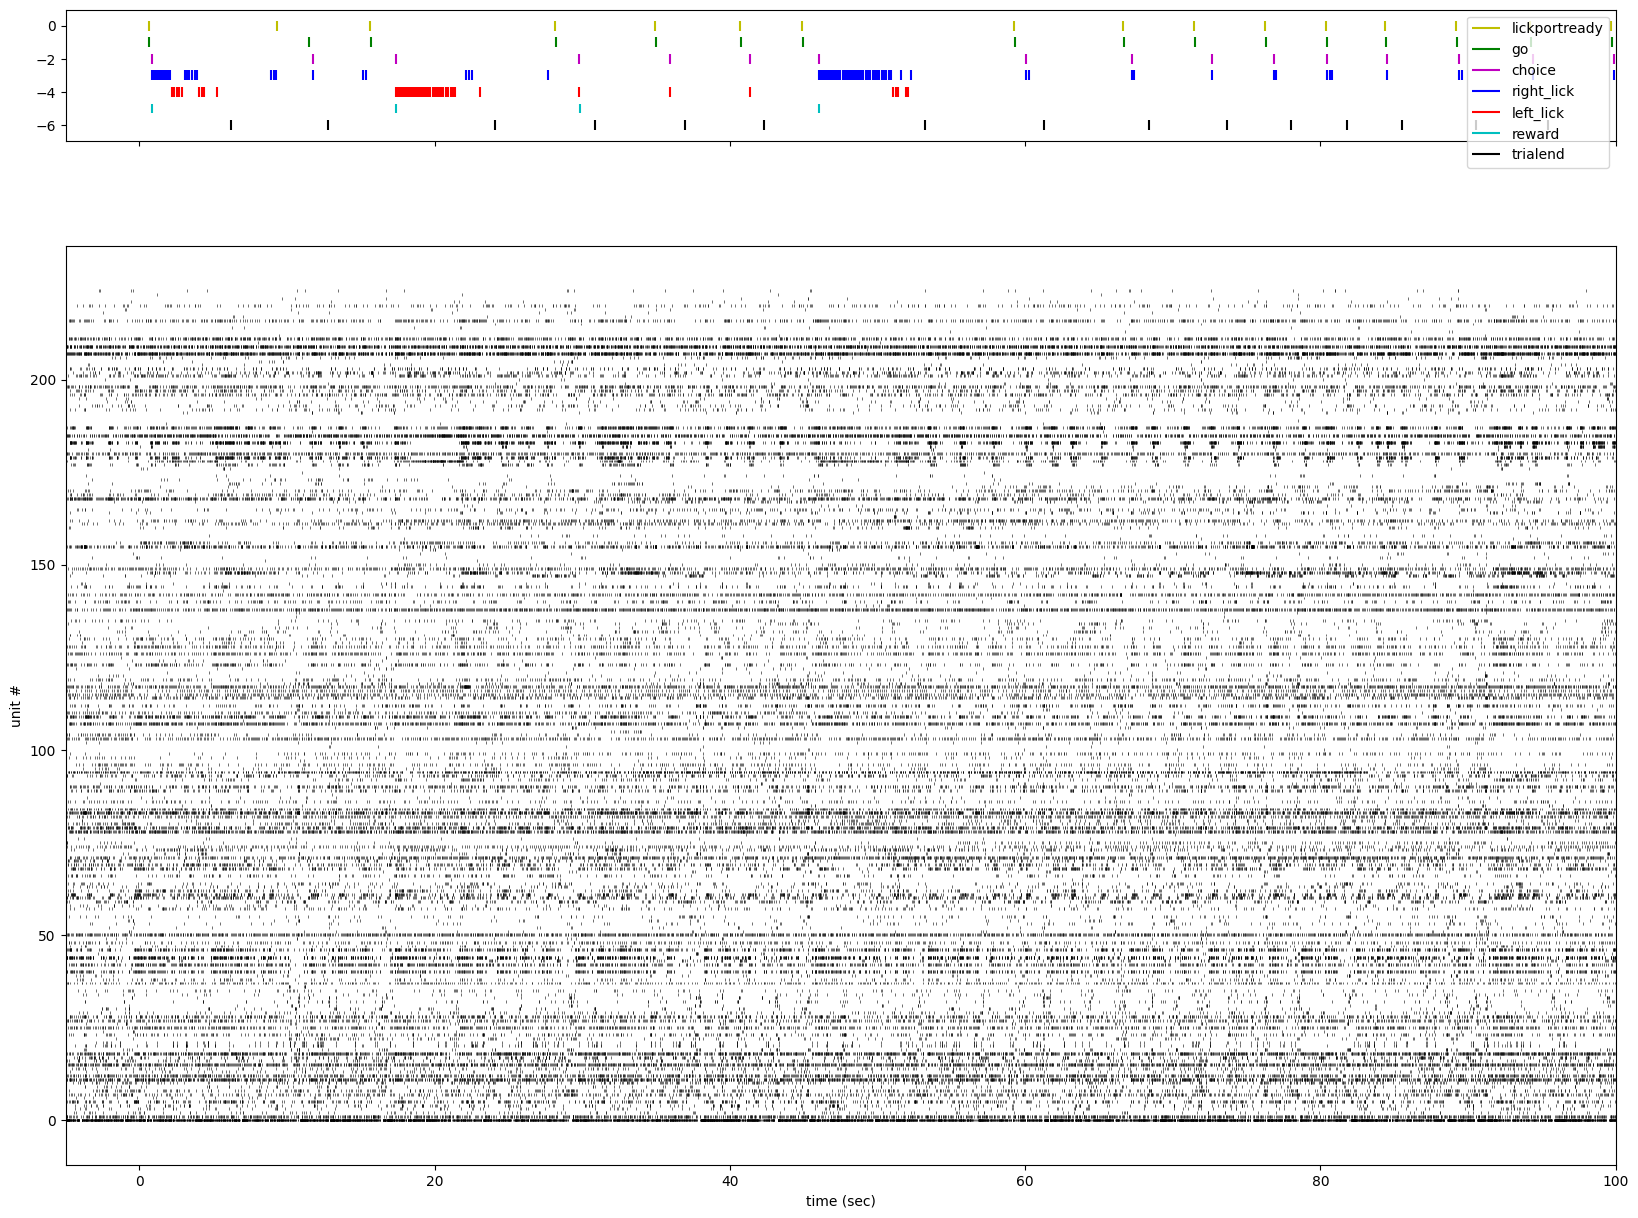

In [63]:
t_start, t_end = -5, 100

spike_times = df_units.spike_times
spike_times = [x[(x > t_start)&(x < t_end)] for x in spike_times]

event_color_map = {'lickportready': 'y', 'go': 'g', 'choice': 'm', 'right_lick': 'b', 'left_lick': 'r', 'reward': 'c', 'trialend': 'k'}
event_times = [behav_events[x].timestamps[:] for x in event_color_map]

fig = plt.figure(figsize=(20, 15))
axs = fig.subplots(2, 1, sharex=True, gridspec_kw={'height_ratios': [1, 7]})

axs[1].eventplot(spike_times, colors='black', lineoffsets=1, linelengths=0.8, lw=0.4)
axs[0].eventplot(event_times, colors=list(event_color_map.values()), linelengths=0.6, lineoffsets=-1)

axs[0].legend(event_color_map)
axs[1].set(xlim=(t_start, t_end), xlabel='time (sec)', ylabel='unit #')

`CCF` coordinates of each unit can be found in the field `electrodes`

In [103]:
df_units.electrodes.iloc[0]

,location,group,group_name,shank,shank_col,shank_row,electrode_id,ccf_annotation,x,y,z,imp,filtering,rel_x,rel_y,rel_z
id,,,,,,,,,,,,,,,,
384,"{""brain_regions"": ""left PL""}",18005108622 1-384 pynwb.ecephys.ElectrodeGroup...,18005108622 1-384,1,1,1,1,Medial preoptic area,5140.0,6000.0,6158.0,-1.0,,16.0,0.0,NaN


Extract CCFs for all units and add columns back to `df_units`

In [98]:
for ccf in ['x', 'y', 'z', 'ccf_annotation']:
    df_units[ccf] = df_units.electrodes.apply(lambda electrode: electrode[ccf].values[0])
df_units['hemisphere'] = np.where(df_units['z'] <= 5739, 'left', 'right')  # z = 5739 is the middle line
    
df_units[['hemisphere', 'ccf_annotation', 'x', 'y', 'z', 'spike_times']]

,hemisphere,ccf_annotation,x,y,z,spike_times
id,,,,,,
0,right,Medial preoptic area,5140.0,6000.0,6158.0,"[-7.468601606247252, -7.459768271014163, -7.43..."
1,right,Medial preoptic area,5100.0,5900.0,6138.0,"[-7.296834902639293, -7.222834886724357, -7.21..."
2,right,Medial preoptic area,5080.0,5880.0,6138.0,"[-7.013368175008382, -6.29173468647574, -5.863..."
3,right,Anterodorsal preoptic nucleus,4940.0,5600.0,6078.0,"[-6.6464347627599025, -6.531101404622209, -5.7..."
4,right,Anterodorsal preoptic nucleus,5020.0,5760.0,6098.0,"[-7.253134893240878, -7.149168204214442, -7.14..."
...,...,...,...,...,...,...
220,right,Striatum,4800.0,5340.0,5998.0,"[-6.7752347904604955, -6.3183346921965144, -5...."
221,right,Striatum,4320.0,4360.0,5778.0,"[-0.5791667912261378, 12.96613612191701, 21.29..."
222,left,Induseum griseum,4180.0,4040.0,5698.0,"[-6.119467982760248, 9.62813540402432, 10.5696..."


In [99]:
df_units.groupby(['hemisphere', 'ccf_annotation'])['hemisphere'].count()

hemisphere  ccf_annotation                                  
left        Anterior cingulate area, dorsal part, layer 5        7
            Anterior cingulate area, ventral part, layer 2/3     4
            Dorsal peduncular area                               9
            Induseum griseum                                    22
            Infralimbic area, layer 2/3                          2
            Infralimbic area, layer 5                           11
            Prelimbic area, layer 5                             35
            Secondary motor area, layer 2/3                      1
            Secondary motor area, layer 5                        1
            Striatum                                            11
right       Anterodorsal preoptic nucleus                       17
            Hypothalamus                                         2
            Medial preoptic area                                 3
            Medial septal nucleus                               47
 

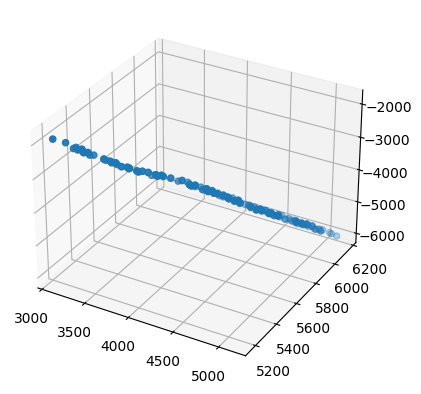

In [104]:
from mpl_toolkits import mplot3d

fig = plt.figure()
 
# syntax for 3-D projection
ax = plt.axes(projection ='3d')

ax.scatter3D(df_units.x, df_units.z, -df_units.y)